In [1]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import torch.nn as nn

from neuralhydrology.utils.config import Config

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

import os

# MISC Function Test

In [2]:
from neuralhydrology.modelzoo.cfe_modules.dcfe_utils import get_dcfe_params
from neuralhydrology.datautils import utils

In [3]:
#config_path = Path('/Users/ziyu/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Documents/College/ResearchStuff/NextGen/neuralhydrology-dcfe/examples/07-DCFE/2basinTest_dynamic.yml')
config_path = Path('2basinTest_dynamic.yml')
config = Config(config_path, dev_mode=True)
basins = utils.load_basin_file(getattr(config, "train_basin_file"))

testDF = get_dcfe_params(config)
testDF.loc['02177000']

depth                                                        tensor(2.)
bb                                                       tensor(1.8747)
satdk                                                    tensor(0.0007)
satpsi                                                   tensor(0.1889)
slop                                                     tensor(0.8340)
smcmax                                                   tensor(0.2987)
wltsmc                                                   tensor(0.0521)
D                                                            tensor(2.)
mult                                                         tensor(1.)
catchment_area_km2                                     tensor(111.1100)
refkdt                                                   tensor(0.8883)
max_gw_storage                                           tensor(0.2016)
expon                                                    tensor(1.8009)
Cgw                                                      tensor(

We expect the above to return 
depth                                                        tensor(2.)
bb                                                       tensor(1.8747)
satdk                                                    tensor(0.0007)
satpsi                                                   tensor(0.1889)
slop                                                     tensor(0.8340)
smcmax                                                   tensor(0.2987)
wltsmc                                                   tensor(0.0521)
D                                                            tensor(2.)
mult                                                         tensor(1.)
catchment_area_km2                                     tensor(111.1100)
refkdt                                                   tensor(0.8883)
max_gw_storage                                           tensor(0.2016)
expon                                                    tensor(1.8009)
Cgw                                                      tensor(0.0003)
alpha_fc                                                 tensor(0.3300)
K_nash                                                   tensor(0.0980)
K_lf                                                     tensor(0.8121)
nash_storage                                   [tensor(0.), tensor(0.)]
giuh_ordinates        [tensor(0.3300), tensor(0.2900), tensor(0.1900...
Name: 02177000, dtype: object

# Dynamic Daily

In [4]:
start_run(config_file=Path("2basinTest_dynamic.yml"), gpu=-1)

2025-12-09 10:18:35,242: Logging to /Users/danielmckenzie/Documents/Active_Research/Ziyu/neuralhydrology-dcfe/examples/07-DCFE/runs/DevMultiBasin_Test_0912_101835/output.log initialized.
2025-12-09 10:18:35,242: ### Folder structure created at /Users/danielmckenzie/Documents/Active_Research/Ziyu/neuralhydrology-dcfe/examples/07-DCFE/runs/DevMultiBasin_Test_0912_101835
2025-12-09 10:18:35,243: ### Run configurations for DevMultiBasin_Test
2025-12-09 10:18:35,243: experiment_name: DevMultiBasin_Test
2025-12-09 10:18:35,243: train_basin_file: 2_basin.txt
2025-12-09 10:18:35,244: validation_basin_file: 2_basin.txt
2025-12-09 10:18:35,244: test_basin_file: 2_basin.txt
2025-12-09 10:18:35,244: train_start_date: 2000-10-01 00:00:00
2025-12-09 10:18:35,245: train_end_date: 2014-09-30 00:00:00
2025-12-09 10:18:35,245: validation_start_date: 1990-10-01 00:00:00
2025-12-09 10:18:35,245: validation_end_date: 1999-09-30 00:00:00
2025-12-09 10:18:35,245: test_start_date: 1999-10-01 00:00:00
2025-12-

### Diagnostics
Let's load the model up and view some outputs as well as internal states.

In [5]:
run_dir = Path("runs/DevMultiBasin_Test_0812_114158")
eval_run(run_dir=run_dir, period="test")

2025-12-09 10:24:55,861: Using the model weights from runs/DevMultiBasin_Test_0812_114158/model_epoch003.pt
Metrics for 1D are calculated over last 1 elements only. Ignoring 364 predictions per sequence.
# Evaluation: 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]
2025-12-09 10:24:56,636: Stored metrics at runs/DevMultiBasin_Test_0812_114158/test/model_epoch003/test_metrics.csv
2025-12-09 10:24:56,636: Stored results at runs/DevMultiBasin_Test_0812_114158/test/model_epoch003/test_results.p


In [6]:
with open(run_dir / "test" / "model_epoch003" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['02177000', '02349900'])

In [7]:
results['02177000']['1D']['xr']

<xarray.Dataset> Size: 9kB
Dimensions:         (date: 2, time_step: 365)
Coordinates:
  * date            (date) datetime64[ns] 16B 2000-09-29 2000-09-30
  * time_step       (time_step) int64 3kB -364 -363 -362 -361 ... -3 -2 -1 0
Data variables:
    QObs(mm/d)_obs  (date, time_step) float32 3kB 0.9633 0.7989 ... 0.6118
    QObs(mm/d)_sim  (date, time_step) float32 3kB 2.47 1.947 ... 1.196 1.159

In [10]:
qobs = results['02177000']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['02177000']['1D']['xr']['QObs(mm/d)_sim']
print(qsim.values.shape)
print(qsim['date'].shape)

(2, 365)
(2,)


ValueError: x and y must have same first dimension, but have shapes (2,) and (365,)

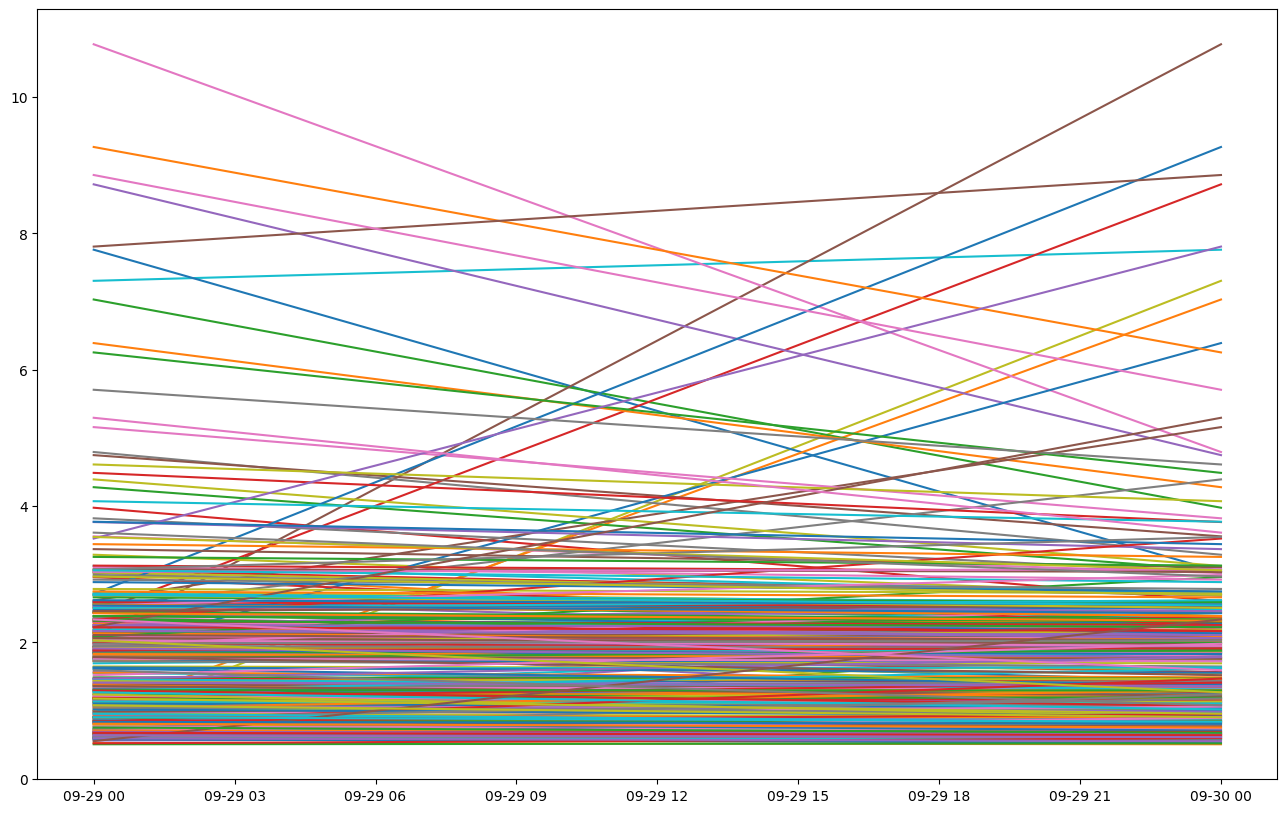

In [9]:
# extract observations and simulations
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs)
ax.plot(qsim['date'], qsim.values[1])
ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['02177000']['1D']['NSE']:.3f}")